<a href="https://colab.research.google.com/github/gksals8378/Teeth_Segmentation/blob/main/Teeth_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import os
import json

# Set the paths to the image and mask folders
image_folder = '/content/drive/MyDrive/data/dental_X-ray_images/Teeth Segmentation PNG/d2/img'
mask_folder = '/content/drive/MyDrive/data/dental_X-ray_images/Teeth Segmentation PNG/d2/ann'

with open('/content/drive/MyDrive/data/dental_X-ray_images/Teeth Segmentation PNG/meta.json', 'r') as f:
    meta_data = json.load(f)

# List all image and mask files
image_files = os.listdir(image_folder)
mask_files = os.listdir(mask_folder)

class_info_map = {cls["title"]: cls for cls in meta_data["classes"]}


target_size = (256, 256)
images = []
masks = []

# 이미지 파일을 반복합니다.
for image_filename in image_files:
    image_path = os.path.join(image_folder, image_filename)
    mask_filename = f'{image_filename}.json'
    mask_path = os.path.join(mask_folder, mask_filename)

    if os.path.exists(mask_path):
        # JSON 파일에서 마스크 데이터를 로드합니다.
        with open(mask_path, 'r') as f:
            mask_data = json.load(f)

        mask_objects = mask_data['objects']

        # 이미지를 로드합니다.
        image = cv2.imread(image_path)

        # 이미지 크기를 조정합니다.
        image = cv2.resize(image, target_size)

        # 타겟 이미지와 동일한 모양의 마스크 배열을 초기화합니다.
        mask = np.zeros(image.shape, dtype=np.uint8)

        # 이미지 크기 조정 비율 계산
        scale_x = image.shape[1] / mask_data["size"]["width"]
        scale_y = image.shape[0] / mask_data["size"]["height"]

        # 각 마스크 오브젝트를 처리합니다.
        for mask_object in mask_objects:
            class_title = mask_object['classTitle']
            class_info = class_info_map.get(class_title)

            if class_info:
                # 마스크 좌표를 이미지 크기에 맞게 조정
                exterior_points = mask_object['points']['exterior']
                mask_polygon = np.array(exterior_points, np.int32)
                mask_polygon = (mask_polygon * [scale_x, scale_y]).astype(np.int32)

                class_color = [int(class_info["color"][i:i + 2], 16) for i in (1, 3, 5)]
                cv2.fillPoly(mask, [mask_polygon], class_color)

        images.append(image)
        masks.append(mask)

    #     # 원본 이미지를 표시합니다.
    #     cv2_imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    #     # 색상을 유지한 채로 마스크 이미지를 표시합니다.
    #     cv2_imshow(mask)
    else:
        print(f"마스크 정보를 찾을 수 없습니다: {image_filename}")
    # break

마스크 정보를 찾을 수 없습니다: zoomed_0.jpg
마스크 정보를 찾을 수 없습니다: zoomed_1.jpg
마스크 정보를 찾을 수 없습니다: zoomed_2.jpg
마스크 정보를 찾을 수 없습니다: zoomed_3.jpg
마스크 정보를 찾을 수 없습니다: zoomed_4.jpg


In [ ]:
from sklearn.model_selection import train_test_split
from torchvision.transforms import ToTensor
import torch

X, y = [], []

for i in range(len(images)):
  X.append(ToTensor()(images[i]))
  y.append(ToTensor()(masks[i]))

X = torch.stack(X)
y = torch.stack(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from  torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

BATCH_SIZE = 8
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

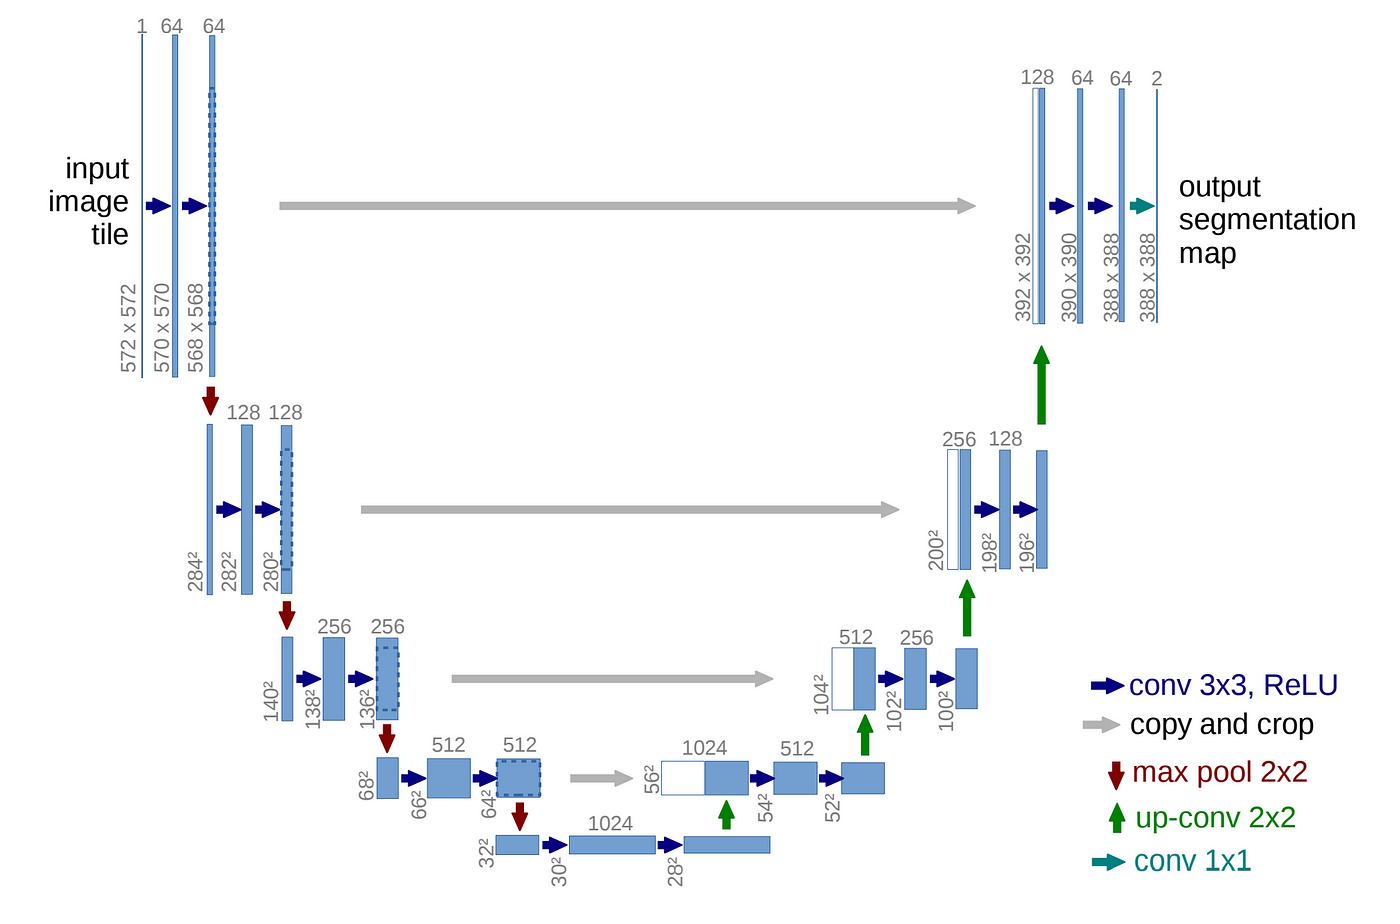

In [ ]:
import torch.nn as nn
from torchsummary import summary

class UNet(nn.Module):
  def __init__(self):
    super(UNet, self).__init__()

    # encoding
    self.enc1_1 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1, bias=True),
                                nn.BatchNorm2d(num_features=64),
                                nn.ReLU())
    self.enc1_2 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=True),
                                nn.BatchNorm2d(num_features=64),
                                nn.ReLU())
    self.pool1 = nn.MaxPool2d(kernel_size=2)

    self.enc2_1 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1, bias=True),
                                nn.BatchNorm2d(num_features=128),
                                nn.ReLU())
    self.enc2_2 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1, bias=True),
                                nn.BatchNorm2d(num_features=128),
                                nn.ReLU())
    self.pool2 = nn.MaxPool2d(kernel_size=2)

    self.enc3_1 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1, bias=True),
                                nn.BatchNorm2d(num_features=256),
                                nn.ReLU())
    self.enc3_2 = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, bias=True),
                                nn.BatchNorm2d(num_features=256),
                                nn.ReLU())
    self.pool3 = nn.MaxPool2d(kernel_size=2)

    self.enc4_1 = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1, bias=True),
                                nn.BatchNorm2d(num_features=512),
                                nn.ReLU())
    self.enc4_2 = nn.Sequential(nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1, bias=True),
                                nn.BatchNorm2d(num_features=512),
                                nn.ReLU())
    self.pool4 = nn.MaxPool2d(kernel_size=2)

    self.enc5_1 = nn.Sequential(nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1, bias=True),
                                nn.BatchNorm2d(num_features=1024),
                                nn.ReLU())

    # decoding
    self.dec5_1 = nn.Sequential(nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, stride=1, padding=1, bias=True),
                                nn.BatchNorm2d(num_features=512),
                                nn.ReLU())
    self.unpool4 = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=2, stride=2, padding=0, bias=True)

    self.dec4_2 = nn.Sequential(nn.Conv2d(in_channels=512 * 2, out_channels=512, kernel_size=3, stride=1, padding=1, bias=True),
                                nn.BatchNorm2d(num_features=512),
                                nn.ReLU())
    self.dec4_1 = nn.Sequential(nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1, bias=True),
                                nn.BatchNorm2d(num_features=256),
                                nn.ReLU())
    self.unpool3 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2, stride=2, padding=0, bias=True)

    self.dec3_2 = nn.Sequential(nn.Conv2d(in_channels=256 * 2, out_channels=256, kernel_size=3, stride=1, padding=1, bias=True),
                                nn.BatchNorm2d(num_features=256),
                                nn.ReLU())
    self.dec3_1 = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1, bias=True),
                                nn.BatchNorm2d(num_features=128),
                                nn.ReLU())
    self.unpool2 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=2, stride=2, padding=0, bias=True)

    self.dec2_2 = nn.Sequential(nn.Conv2d(in_channels=128 * 2, out_channels=128, kernel_size=3, stride=1, padding=1, bias=True),
                                nn.BatchNorm2d(num_features=128),
                                nn.ReLU())
    self.dec2_1 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1, bias=True),
                                nn.BatchNorm2d(num_features=64),
                                nn.ReLU())
    self.unpool1 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2, stride=2, padding=0, bias=True)

    self.dec1_2 = nn.Sequential(nn.Conv2d(in_channels=64 * 2, out_channels=64, kernel_size=3, stride=1, padding=1, bias=True),
                                nn.BatchNorm2d(num_features=64),
                                nn.ReLU())
    self.dec1_1 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=True),
                                nn.BatchNorm2d(num_features=64),
                                nn.ReLU())

    self.fc = nn.Conv2d(in_channels=64, out_channels=3, kernel_size=1, stride=1, padding=0, bias=True)

  def forward(self, x):
    enc1_1 = self.enc1_1(x)
    enc1_2 = self.enc1_2(enc1_1)
    pool1 = self.pool1(enc1_2)

    enc2_1 = self.enc2_1(pool1)
    enc2_2 = self.enc2_2(enc2_1)
    pool2 = self.pool2(enc2_2)

    enc3_1 = self.enc3_1(pool2)
    enc3_2 = self.enc3_2(enc3_1)
    pool3 = self.pool3(enc3_2)

    enc4_1 = self.enc4_1(pool3)
    enc4_2 = self.enc4_2(enc4_1)
    pool4 = self.pool4(enc4_2)

    enc5_1 = self.enc5_1(pool4)

    dec5_1 = self.dec5_1(enc5_1)

    unpool4 = self.unpool4(dec5_1)
    # bridge
    cat4 = torch.cat((unpool4, enc4_2), dim=1)
    dec4_2 = self.dec4_2(cat4)
    dec4_1 = self.dec4_1(dec4_2)

    unpool3 = self.unpool3(dec4_1)
    # bridge
    cat3 = torch.cat((unpool3, enc3_2), dim=1)
    dec3_2 = self.dec3_2(cat3)
    dec3_1 = self.dec3_1(dec3_2)

    unpool2 = self.unpool2(dec3_1)
    # bridge
    cat2 = torch.cat((unpool2, enc2_2), dim=1)
    dec2_2 = self.dec2_2(cat2)
    dec2_1 = self.dec2_1(dec2_2)

    unpool1 = self.unpool1(dec2_1)
    # bridge
    cat1 = torch.cat((unpool1, enc1_2), dim=1)
    dec1_2 = self.dec1_2(cat1)
    dec1_1 = self.dec1_1(dec1_2)

    x = self.fc(dec1_1)

    return x

x = torch.rand(1, 3, 256, 256)
model = UNet()

x = x.to('cuda')
model = model.to('cuda')

model.forward(x)
summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
         MaxPool2d-7         [-1, 64, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]          73,856
       BatchNorm2d-9        [-1, 128, 128, 128]             256
             ReLU-10        [-1, 128, 128, 128]               0
           Conv2d-11        [-1, 128, 128, 128]         147,584
      BatchNorm2d-12        [-1, 128, 128, 128]             256
             ReLU-13        [-1, 128, 128, 128]               0
        MaxPool2d-14          [-1, 128,

In [ ]:
from torch.optim import SGD
from torch.utils.tensorboard import SummaryWriter

if torch.cuda.is_available() : DEVICE = 'cuda'
elif torch.backends.mps.is_available() : DEVICE = 'mps'
else : DEVICE = 'cpu'
print(DEVICE)

LR = 0.001

net = UNet().to(DEVICE)
criterion  = nn.BCEWithLogitsLoss().to(DEVICE)
optimizer = torch.optim.Adam(net.parameters(), lr=LR)
writer = SummaryWriter()

cuda


In [ ]:
from tqdm import tqdm

EPOCHS = 20

for epoch in range(EPOCHS):
  net.train()
  running_loss = 0.0

  for X, y in tqdm(train_dataloader):
    X, y = X.to(DEVICE), y.to(DEVICE)

    optimizer.zero_grad()
    outputs = net(X)
    loss = criterion (outputs, y)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  print("TRAIN: EPOCH %04d / %04d | LOSS %.4f" %
       (epoch + 1, EPOCHS, running_loss / len(train_dataloader)))
  writer.add_scalar('train_loss', running_loss / len(train_dataloader), epoch)
writer.close()

100%|██████████| 60/60 [00:23<00:00,  2.56it/s]


TRAIN: EPOCH 0001 / 0020 | LOSS 0.3464


100%|██████████| 60/60 [00:23<00:00,  2.53it/s]


TRAIN: EPOCH 0002 / 0020 | LOSS 0.1874


100%|██████████| 60/60 [00:23<00:00,  2.50it/s]


TRAIN: EPOCH 0003 / 0020 | LOSS 0.1589


100%|██████████| 60/60 [00:24<00:00,  2.48it/s]


TRAIN: EPOCH 0004 / 0020 | LOSS 0.1486


100%|██████████| 60/60 [00:24<00:00,  2.46it/s]


TRAIN: EPOCH 0005 / 0020 | LOSS 0.1428


100%|██████████| 60/60 [00:24<00:00,  2.45it/s]


TRAIN: EPOCH 0006 / 0020 | LOSS 0.1395


100%|██████████| 60/60 [00:24<00:00,  2.42it/s]


TRAIN: EPOCH 0007 / 0020 | LOSS 0.1343


100%|██████████| 60/60 [00:25<00:00,  2.36it/s]


TRAIN: EPOCH 0008 / 0020 | LOSS 0.1291


100%|██████████| 60/60 [00:25<00:00,  2.35it/s]


TRAIN: EPOCH 0009 / 0020 | LOSS 0.1245


100%|██████████| 60/60 [00:25<00:00,  2.39it/s]


TRAIN: EPOCH 0010 / 0020 | LOSS 0.1218


100%|██████████| 60/60 [00:25<00:00,  2.37it/s]


TRAIN: EPOCH 0011 / 0020 | LOSS 0.1193


100%|██████████| 60/60 [00:25<00:00,  2.36it/s]


TRAIN: EPOCH 0012 / 0020 | LOSS 0.1163


100%|██████████| 60/60 [00:25<00:00,  2.37it/s]


TRAIN: EPOCH 0013 / 0020 | LOSS 0.1173


100%|██████████| 60/60 [00:25<00:00,  2.37it/s]


TRAIN: EPOCH 0014 / 0020 | LOSS 0.1153


100%|██████████| 60/60 [00:25<00:00,  2.36it/s]


TRAIN: EPOCH 0015 / 0020 | LOSS 0.1135


100%|██████████| 60/60 [00:25<00:00,  2.36it/s]


TRAIN: EPOCH 0016 / 0020 | LOSS 0.1119


100%|██████████| 60/60 [00:25<00:00,  2.36it/s]


TRAIN: EPOCH 0017 / 0020 | LOSS 0.1107


100%|██████████| 60/60 [00:25<00:00,  2.36it/s]


TRAIN: EPOCH 0018 / 0020 | LOSS 0.1102


100%|██████████| 60/60 [00:25<00:00,  2.36it/s]


TRAIN: EPOCH 0019 / 0020 | LOSS 0.1095


100%|██████████| 60/60 [00:25<00:00,  2.36it/s]

TRAIN: EPOCH 0020 / 0020 | LOSS 0.1086


In [ ]:
torch.save(net.state_dict(), 'unet_segmentation_model.pth')

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm

num_data_test = len(test_dataset)
num_batch_test = np.ceil(num_data_test / BATCH_SIZE)

fn_tonumpy = lambda x: x.to('cpu').detach().numpy().transpose(0, 2, 3, 1)
fn_denorm = lambda x, mean, std: (x * std) + mean
fn_class = lambda x: (x > 0.5).float()

result_dir = os.path.join("results")
os.makedirs(os.path.join(result_dir, 'png'), exist_ok=True)
os.makedirs(os.path.join(result_dir, 'numpy'), exist_ok=True)


with torch.no_grad():
    net.eval()
    loss_arr = []

    for batch, data in enumerate(test_dataloader, 1):
        X, y = data

        X = X.to(DEVICE).float()
        y = y.to(DEVICE).float()

        output = net(X)

        loss = criterion(output, y)
        loss_arr += [loss.item()]

        print("TEST: BATCH %04d / %04d | LOSS %.4f" %
              (batch, num_batch_test, np.mean(loss_arr)))


        # 결과 저장
        input = fn_tonumpy(X)
        label = fn_tonumpy(fn_denorm(y, mean=0.5, std=0.5))
        output = fn_tonumpy(fn_class(output))

        for j in range(input.shape[0]):
            id = num_batch_test * (batch - 1) + j

            # 결과 이미지 및 numpy 배열 저장
            label_path = os.path.join(result_dir, 'png', 'label_%04d.png' % id)
            input_path = os.path.join(result_dir, 'png', 'input_%04d.png' % id)
            output_path = os.path.join(result_dir, 'png', 'output_%04d.png' % id)

            # 이미지 저장
            plt.imsave(label_path, np.clip(label[j].squeeze(), 0, 1))
            plt.imsave(input_path, np.clip(input[j].squeeze(), 0, 1))
            plt.imsave(output_path, np.clip(output[j].squeeze(), 0, 1))

            # numpy 배열 저장
            np.save(os.path.join(result_dir, 'numpy', 'label_%04d.npy' % id), label[j].squeeze())
            np.save(os.path.join(result_dir, 'numpy', 'input_%04d.npy' % id), input[j].squeeze())
            np.save(os.path.join(result_dir, 'numpy', 'output_%04d.npy' % id), output[j].squeeze())

print("AVERAGE TEST: BATCH %04d / %04d | LOSS %.4f" %
      (batch, num_batch_test, np.mean(loss_arr)))

TEST: BATCH 0001 / 0015 | LOSS 0.1357
TEST: BATCH 0002 / 0015 | LOSS 0.1198
TEST: BATCH 0003 / 0015 | LOSS 0.1123
TEST: BATCH 0004 / 0015 | LOSS 0.1110
TEST: BATCH 0005 / 0015 | LOSS 0.1126
TEST: BATCH 0006 / 0015 | LOSS 0.1129
TEST: BATCH 0007 / 0015 | LOSS 0.1071
TEST: BATCH 0008 / 0015 | LOSS 0.1072
TEST: BATCH 0009 / 0015 | LOSS 0.1057
TEST: BATCH 0010 / 0015 | LOSS 0.1068
TEST: BATCH 0011 / 0015 | LOSS 0.1055
TEST: BATCH 0012 / 0015 | LOSS 0.1061
TEST: BATCH 0013 / 0015 | LOSS 0.1061
TEST: BATCH 0014 / 0015 | LOSS 0.1078
TEST: BATCH 0015 / 0015 | LOSS 0.1082
AVERAGE TEST: BATCH 0015 / 0015 | LOSS 0.1082


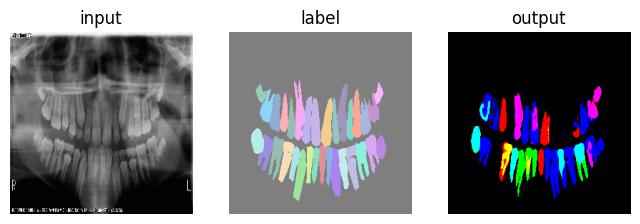

In [ ]:
##
lst_data = os.listdir(os.path.join(result_dir, 'numpy'))

lst_label = [f for f in lst_data if f.startswith('label')]
lst_input = [f for f in lst_data if f.startswith('input')]
lst_output = [f for f in lst_data if f.startswith('output')]

lst_label.sort()
lst_input.sort()
lst_output.sort()

##
id = 0

label = np.load(os.path.join(result_dir,"numpy", lst_label[id]))
input = np.load(os.path.join(result_dir,"numpy", lst_input[id]))
output = np.load(os.path.join(result_dir,"numpy", lst_output[id]))

## 플롯 그리기
plt.figure(figsize=(8,6))
plt.subplot(131)
plt.imshow(input)
plt.title('input')
plt.axis('off')

plt.subplot(132)
plt.imshow(label)
plt.title('label')
plt.axis('off')

plt.subplot(133)
plt.imshow(output)
plt.title('output')
plt.axis('off')

plt.show()